# Классификация текстов. Предсказание индекса Доу Джонса #

## Постановка задачи и формулировка задания ##
В качестве входных данных для предсказания индекса Доу Джонса по заголовкам новостей у нас есть датасет, в котором в качестве меток класса используется изменение индекса за день (1 -- повысился или не изменился, 0 -- понизился), в качестве данных для классификации -- топ 25 заголовков новостей за день. 

В наши задачи входит:
1. Предварительная обработка текста;
2. Обучение классификатора новостей для предсказания индекса;
3. Поиск решений для улучшения результатов классификации.


### Алгоритм решения поставленных задач ###
Будет подробно описан в тексте ноутбука при написании кода.

## Описание инструментов ##
Ниже будут описаны используемые инструменты, принципы их работы, основная теория.

### Классификаторы ###

Для решения задачи классификации мы решили воспользоваться двумя классификаторами и в качестве небольшого исследования оценить разницу в качестве классификации и выборе параметров для каждого из классификаторов.

В экспериментах мы также последовательно будем применять векторизацию текстов при помощи модели мешка слов (CountVectorizer) и tf-idf преобразования. 

**Мультиномиальный наивный Байес**

В методе классификации наивного Байеса определяется вероятность принадлежности документа к классу при том, что термин t определяет этот класс (апостериорная вероятность) и с учетом вероятности, с которой этот класс существует (апостериорная вероятность). 

Условная вероятность, а точнее ее логарифм, отражает вес термина (его важность) для этого документа. Таким образом, сложив веса терминов и сумму логарифмов вероятности какого-то класса мы получаем подтверждение его существования. 

Векторизация признаков в пространстве происходит при векторизации (модель мешка слов).

Однако при представлении слова в виде вектора возникают некоторые проблемы: если слово предстает перед нами как вектор с координатами в пространстве, где координаты -- это признаки, то мы не считаем эти признаки разными, а приравниваем их друг к другу. То есть, если слово встречается в документе несколько раз, то в разных координатах мы присвоим ему одно и то же значение. Однако если в обучающей выборке пара термин-класс не встречается, то условная принадлежность термина к классу будет равна нулю, так как при перемножении вероятностей, где хотя бы одна равна нулю -- получаем ноль и значимость всех остальных признаков для отнесения к классу исчезает. 

Для того, чтобы избавиться от подобных случаев используется *сглаживание Лапласа*, в котором к частоте каждого термина прибавляется единица или любой другой коэффициент, не равный нулю. Выбор коэффициента зависит от суммы вероятностей предыдущих исходов (в идеальном случае сумма всех вероятностей должна равняться нулю), но если он не известен, то **alpha** просто выставляют 1. В нашем случае мы попробуем поэкспериментировать с разными значаениями и найти наилучший результат эмпирически.

**Метод опорных векторов (Linear SVC)**

Метод опорных векторов -- это метод основывающийся на поиске разделяющей плоскости в многомерном пространстве. Опорными векторами называются точки, расположенные ближе всего к разделяющей плоскости. 

Задача алгоритма -- максимизировать ширину разделяющей полосы, проходящей между экземплярами единиц двух классов. С максимизацией расстояния между единицами классов вероятность "сомнения" классификатора в принятии решения о принадлежности к классу снижается, в то время как если бы полоса была слишком узкой, вероятность отнести элементы к неверному классу сильно возрастает.

### TF-IDF преобразование ###

TF-IDF мера помогает нормировать текст, определяя наиболее важные слова (с большим весом) и отсеивая слишком частотные или очень редкие слова. Эта мера также может помочь нам существенно улучшить качество классификации, для этого мы ее и будем использовать.

### Сингулярное разложение ###

Сингулярное разложение -- еще один способ улучшить качество классификации.

Оно используется для того, чтобы сократить размерность пространства признаков, которыми мы характеризуем каждый документ.

В результате разложения получается три матрицы, перемноженных между собой, на диагонали такой матрицы расположены сингулярные числа и их столько, сколько слов в нашем словаре. Мы оставляем заданное число этих сингулярных чисел (n компонент, которые задаются в методе), остальные обнуляем. В результате при обратном перемножении размерность пространства признаков (количество слов) сократится до заданного n. Это может улучшить качество классификации, поскольку мы избавляемся от ненужных признаков и оставляем только значимые.

In [917]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr
from nltk.tokenize import word_tokenize
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [70]:
df_news_initial = pd.read_csv('/home/nst/mount/data/linguistics_hse/machine_learning/hw2_classification/stocknews/Combined_News_DJIA.csv', encoding='utf-8')

In [852]:
df_news_initial.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."


## Часть I. Предобработка текста и работа с корреляциями ##

### Предобработка текста ###

В нашем случае предобработка текстов будет заключаться в том, чтобы удалить знаки препинания и привести тексты к нижнему регистру, избавиться от символов кодировки binary, в которых была закодирована часть текстов.

По нашему мнению, лемматизация или стемминг не сильно помогут в обработке, поскольку английский язык не такой флективный как, например, русский, где целых шесть лексем будут принадлежать к одной лемме, так как в русском языке 6 падежей (в английском языке для существительных будет всего две формы -- единственное и множественное число: *dog -- dogs*).

Все остальные операции (векторизацию, удаление стоп-слов) можно выполнять из пакета **sklearn**.

Функция `preprocess_to_list` принимает на вход датафрейм, а возвращает список текстов, где все 25 топовых заголовков за день будут представлены в виде одного текста. Это нужно для удобства работы с данными: все характеристики для корреляций мы будем считать именно по ним, а также извлекать признаки для обучения классификаторов.

In [1012]:
def preprocess(text_string):
    cases = ('b\'', 'b\"')
    for prefix in cases:
        if text_string.startswith(prefix):
            text_string = text_string[1:]
    low_text = text_string.lower()
    del_punctuation = re.findall(r'\w+', low_text)
    str_heading_text = ' '.join(del_punctuation)
    return str_heading_text

In [1006]:
def preprocess_to_list(data_frame):
    texts_list = []
    for index in range(len(data_frame)):
        single_row = data_frame.loc[index:index, :]
        headings_array = single_row.get_values()
        for row in headings_array:
            row_texts_list = []
            for heading in row:
                if heading is np.nan:
                    print('Heading type nan:', heading)
                    row_texts_list.append('')                
                    continue
                str_heading_text = preprocess(heading)
                row_texts_list.append(str_heading_text)
            row_texts_list = ' '.join(row_texts_list)
            texts_list.append(row_texts_list)
    return texts_list

In [944]:
single_row = df_news_initial.loc[0:0, :]
headings_array = single_row.get_values()

**Есть ли корреляция между средней длинной текста за день и DJIA?**

Поскольку одна из наших переменных (изменение индекса) дихотомическая, нам необходимо использовать метод точечной двухрядной корреляцию (Point-Biserial Correlation). Она является частным случаем корреляции Пирса

Для получения индекса корреляции используем функцию из модуля `scipy.stats`, из которой на выходе получаем значение индекса корреляции (первое значение) и p-value (второе значение). Затем построим график распределения величин.

In [890]:
labels = df_news_initial['Label']
labels = labels.get_values()

In [202]:
df_tops = df_news_initial.loc[:, 'Top1':'Top25']

In [204]:
len(df_tops)

1989

Извлекаем параметры корреляции (подсчет средней длины текста за день). В функции необходимо учесть, что есть и пустые заголовки (nan). На выходе из функции `count_mean_per_row` получаем numpy array c посчитаным средним значением.

In [1200]:
def count_mean_per_row(data_frame):
    means_list = []
    
    for index in range(len(data_frame)):
        single_row = data_frame.loc[index:index, :]
        headings_array = single_row.get_values()
        
        for row in headings_array:
            count_words_list = []
            for heading in row:
                if heading is np.nan:
                    print('Heading type nan:', heading)
                    count_words_list.append(0)
                    continue
                heading = preprocess(heading)
                heading = heading.split()
                count_words = (len(heading))
                count_words_list.append(count_words)
            row_mean = sum(count_words_list)/25
            means_list.append(row_mean)

            count_words_list.append(1)

    means_array = np.array(means_list)
    return means_array    
           

Функция проходится по каждому тексту из коллекции, удаляет знаки препинания и ненужные binary символы, считает длину отдельного заголовка, общую длину всех заголовков за день и находит среднее значение.

In [1201]:
means = count_mean_per_row(df_tops)

Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan


In [914]:
means

array([ 15.28,  10.88,  14.48, ...,  15.6 ,  18.  ,  20.8 ])

In [911]:
corr_index = pointbiserialr(labels, means)
corr_index

PointbiserialrResult(correlation=-0.0064443894451112821, pvalue=0.77393582182950416)

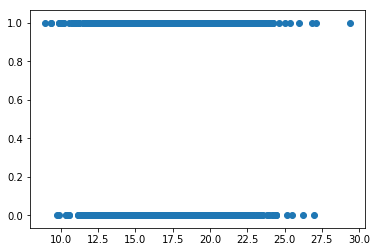

In [916]:
plt.scatter(means, labels)
plt.show()

Поскольку индекс корреляции близок к нулю, можно считать, что корреляции между двумя признаками нет.

**Есть ли корреляция между количеством упоминаний Барака Обамы и США в день и DJIA?**

Посчитаем количество упоминаний Барака Обамы и США в день. Учтем все возможные написания США (USA, U.S., US, United States, America). Обратим внимание, что для того, чтобы найти все упоминания в тексте, нам не надо приводить его к нижнему регистру иначе сочетания символов могут войти в часть другого слова. Например: **usa**ge.

Ищем следующие строки:
- Obama
- Barack Obama
- USA
- U.S.
- US
- United States
- America


In [978]:
def preprocess_higher_case(data_frame):
    texts_list = []
    for index in range(len(data_frame)):
        single_row = data_frame.loc[index:index, :]
        headings_array = single_row.get_values()
        for row in headings_array:
            row_texts_list = []
            for heading in row:
                if heading is np.nan:
                    print('Heading type nan:', heading)
                    row_texts_list.append('')                
                    continue
                del_punctuation = re.findall(r'\w+', heading)
                str_heading_text = ' '.join(del_punctuation)
                row_texts_list.append(str_heading_text)
            row_texts_list = ' '.join(row_texts_list)
            texts_list.append(row_texts_list)
    return texts_list

In [1015]:
us_obama_lst = preprocess_higher_case(df_tops)

Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan


Пишем функцию, которая считает количество соответствий в тексте всем обозначенным случаям. Берем на вход строку текста, объединяем по вертикальной черте, что в регулярных выражениях интерпретируется как "или". Ищем в строке все случаи, соответствующие нашему регулярному выражению и чтобы сохранить значение итератора упаковываем его в тьюпл, берем его длину.

In [1061]:
def count_obama_us_line(text_line):
    cases = ('Obama', 'Barack Obama', 'USA', 'U.S.', 'US', 'United States', 'America')
    
    regexp = '|'.join(cases)
    return len(tuple(re.finditer(regexp, text_line)))
    
    
#     while True:
        
#         case_indices = [text_line.find(case, index) for case in cases]
#         if all([case_index == -1 for case_index in case_indices]):
#             return case_count

#         case_count += 1
#         positive_indices = [case_index for case_index in case_indices if case_index != -1]
#         min_index = min(positive_indices)
#         index = min_index + 1

assert count_obama_us_line('Obama in USA') == 2
assert count_obama_us_line('God and religion') == 0
assert count_obama_us_line('USACK Obama') == 2, count_obama_us_line('USACK Obama')

Следующая функция берет уже не одну строку, а список текстов. Так мы можем обсчитать каждый из них в цикле.

In [1052]:
def count_obama_us(text_list):
    count = []
    for text in text_list:
        num_words = count_obama_us_line(text)
        count.append(num_words)
    count_array = np.array(count)
    return count_array

In [1053]:
c_obama_us = count_obama_us(us_obama_lst)

In [1056]:
corr_index = pointbiserialr(labels, c_obama_us)
corr_index

PointbiserialrResult(correlation=0.00067622893237813766, pvalue=0.9759556853451169)

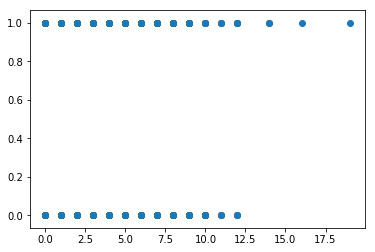

In [1057]:
plt.scatter(c_obama_us, labels)
plt.show()

Корреляции между перменными снова нет. Количество упоминаний США и Барака Обамы в день никак не связаны.

**Каких статей больше: статей о России и Путине или об Исламском государстве (запрещенной законом РФ террористическая организации)?**

Снова нам надо найти строки, в которых встречаются слова:
- Russia
- Russian
- Putin

- ISIS
- Islamic State

Теперь нам надо проанализировать не целую строку за весь день, а каждый отдельный текст в ней, поэтому итерироваться будем по строкам таблицы, создадим array, а затем еще по каждому тексту в строке в отдельном блоке кода.

In [1203]:
def get_values(data_frame):
    headings_list = []
    for index in range(len(data_frame)):
        single_row = data_frame.loc[index:index, :]
        single_row_list = single_row.get_values()
        headings_list.extend(single_row_list)
    headings_array = np.array(headings_list)
    return headings_array

In [1212]:
headings_array = get_values(df_tops)

In [1062]:
def count_cases(text_str, cases):
    regexp = '|'.join(cases)
    return len(tuple(re.finditer(regexp, text_str)))

Функция `count_russia_isis` принимает список, строки в котором сравнивает с тьюплами `cases`. Если значение больше 0, это означает, что в тексте встретились слова из кейса и в зависимости от этого они отправляются в списки, от которых потом берется их длина, что и является количеством текстов. В конце просто сравниваем, каких получилось больше.

In [1079]:
def count_russia_isis(text_list):
    cases_russia = ('Russia', 'Russian', 'Putin')
    cases_isis = ('ISIS', 'Islamic State')
    
    count_cases_russia = len([None for text in text_list
                              if count_cases(text, cases_russia) > 0])

    count_cases_isis = len([None for text in text_list
                            if count_cases(text, cases_isis) > 0])
    if count_cases_russia > count_cases_isis:
        print('There are more articles about Putin and Russia.\nTexts about Russia:',
             count_cases_russia, '\nTexts about ISIS:', count_cases_isis)
    else:
        print('There are more articles about ISIS. \nTexts about ISIS:',
             count_cases_isis, '\nTexts about Russia:', count_cases_russia)


In [1215]:
small_texts_list = []
for row in headings_array:
    for heading in row:
        if heading is np.nan:
            print('Heading type nan:', heading)                
            continue
        small_texts_list.append(heading)
small_texts_arr = np.array(small_texts_list)

Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan


In [1217]:
len(small_texts_arr)

49718

In [1218]:
count_russia_isis(small_texts_arr)

There are more articles about Putin and Russia.
Texts about Russia: 2964 
Texts about ISIS: 845


**О каких кризисах (crisis) пишут статьи?**

Для того, чтобы понять, о каких кризисах идет речь, кроме слова crisis из строки нам нужно выбрать его контекст. Это можно сделать с помощью n-грам. Попробуем использовать 5-граммы, где центральное слово crisis, а два слова справа и слева -- контекст. 

Здесь мы также будем рассматривать каждый заголовок отдельно*, чтобы избежать ситуации, когда слово crisis встречается в тексте более одного раза (возможно, такие случаи тоже встретятся, но будут довольно редки, и это не помешает нам достать основной контекст). 

*Здесь итерация по кажому тексту вшита в саму функцию `get_context_from_array`.

In [1197]:
def get_context(word_list):
#     print('get_context', word_list)
    word_index = word_list.index('crisis')
    left_index = word_index-2
    if left_index < 0:
        left_index = 0
    context = word_list[left_index:(word_index+3)]
    context = ' '.join(context)
    return context
    
    
    
assert get_context(['a', 'crisis', 'b', 'c', 'd']) \
    == 'a crisis b c', \
    get_context(['a', 'crisis', 'b', 'c', 'd'])

In [1198]:
def get_context_from_array(headings_array):
    for row in headings_array:
        for heading in row:
            if heading is np.nan:
                print('Heading type nan:', heading)                
                continue
            heading = preprocess(heading)
            heading = heading.split()
#             print(heading)
            if 'crisis' in heading:
#                 heading = heading.split(preprocess(heading))
                context = get_context(heading)
                print('Context:', context)
            else:
                continue
        

Итак, посмотрим, о каких кризисах идет речь в новостях, выделим наиболее интересные и значимые:

In [1199]:
get_context_from_array(headings_array)

Context: caucasus in crisis georgia invades
Context: forecast georgian crisis 2 days
Context: aids treatment crisis goes critical
Context: the market crisis to be
Context: wall street crisis ahmadinejad
Context: a financial crisis the swedish
Context: the economic crisis that s
Context: and a crisis of the
Context: german bank crisis the transformation
Context: s financial crisis should be
Context: from the crisis
Context: world economic crisis deepens nikkei
Context: the climate crisis
Context: warns of crisis in afghanistan
Context: dwarfs bank crisis
Context: pakistan in crisis on mission
Context: current financial crisis
Context: the financial crisis stocks surge
Context: global economic crisis likely to
Context: world financial crisis deepens
Context: worst food crisis in decade
Context: iceland as crisis deepens
Context: a lifetime crisis and possibly
Context: s financial crisis is escalating
Context: of food crisis
Context: of currency crisis meltdown
Context: money as crisis sp

Context: growing global crisis depression could
Context: the financial crisis
Context: caribbean debt crisis has islands
Context: hit by crisis greek society
Context: gaza crisis tel aviv
Context: global financial crisis grew to
Context: gaza crisis palestinian shot
Context: a political crisis
Context: a financial crisis should be
Context: sperm count crisis biggest ever
Context: syria crisis food aid
Context: despite euro crisis spiegel online
Context: its economic crisis
Context: mali crisis militants killed
Context: air pollution crisis
Context: s economic crisis are finding
Context: if syria crisis worsens
Context: the hostage crisis in algeria
Context: water pollution crisis according to
Context: critical housing crisis hong kongs
Context: prolonged political crisis
Context: north korea crisis gone too
Context: north korea crisis foreign ministry
Context: north korea crisis could escalate
Context: financial crisis caused by
Context: europe s crisis countries hide
Context: the fina

**Кризисы:**
1. Кавказский кризис (война Грузии и Южной Осетии)
2. "Медицинские" кризисы (кризис лечения СПИДа, кризис холеры
3. Мировой финансовый/экономический кризис
4. Климатический кризис
5. Нефтяной кризис
6. Региональные кризисы (Тайланд, Шри-Ланка, Греция, Киргизия, Крым)
7. Кризис насилия на Ближнем Востоке
8. Пищевой кризис
9. Демографический кризис
10. Политические кризисы (политика, беженцы).
11. Энергетический кризис итд.

## Часть II. Классификация ##

Перейдем к решению нашей основной задачи -- классификации.

### Подготовка обучающей и тестовой выборки ###

Из обучающего датафрейма извлечем только те записи, где DJIA равен 0 и прогоним через функцию предобработки `preprocess_to_list`. Поскольку функция отдает нам список из текстов, каждому из них надо снова назначить оригинальную метку класса.

In [1220]:
train = df_news_initial[df_news_initial['Date'] < '2015-01-01']
test = df_news_initial[df_news_initial['Date'] > '2014-12-31']

In [1221]:
train_neg = train.loc[train['Label'] == 0]
train_neg_tops = train_neg.loc[:, 'Top1':'Top25']

In [1232]:
def preprocess_to_list(data_frame):
    texts_list = []
    for index in range(len(data_frame)):
        single_row = data_frame.loc[index:index, :]
        headings_array = single_row.get_values()
        for row in headings_array:
            row_texts_list = []
            for heading in row:
                if heading is np.nan:
                    print('Heading type nan:', heading)
                    row_texts_list.append('')                
                    continue
                str_heading_text = preprocess(heading)
                row_texts_list.append(str_heading_text)
            row_texts_list = ' '.join(row_texts_list)
            texts_list.append(row_texts_list)
    return texts_list

In [1233]:
train_neg_texts = preprocess_to_list(train_neg_tops)

Назначим каждому тексту метку 0 и создадим тьюпл из текстов и меток к ним.

In [1235]:
train_neg_tup = [('0', text) for text in train_neg_texts]

Сделаем то же самое для строк с DJIA 1 и объединим результаты в датасет.

In [1236]:
train_pos = train.loc[train['Label'] == 1]
train_pos_tops = train_pos.loc[:, 'Top1':'Top25']

In [1237]:
train_pos_texts = preprocess_to_list(train_pos_tops)

Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan


In [1238]:
train_pos_tup = [('1', text) for text in train_pos_texts]

In [1239]:
train_tups = train_neg_tup + train_pos_tup

In [1240]:
df_train = pd.DataFrame(train_tups, columns=['class', 'text'])
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()

,class,text
0,1,after finding two groups of males the force ex...
1,1,people are being slaughtered like sheep gunmen...
2,0,the inhumane detention conditions of bradley m...
3,1,defamation of religion is now a human rights v...
4,1,us troops and contractors caused substantial d...


Получаем обучающую выборку. Аналогичным образом обрабатываем тестовые данные.

In [1241]:
test_neg = test.loc[test['Label'] == 0]
test_neg_tops = test_neg.loc[:, 'Top1':'Top25']
test_neg_tops = test_neg_tops.reset_index(drop=True)
test_neg_texts = preprocess_to_list(test_neg_tops)

In [1242]:
test_neg_tup = [('0', text) for text in test_neg_texts]

In [1243]:
test_pos = test.loc[test['Label'] == 1]
test_pos_tops = test_pos.loc[:, 'Top1':'Top25']
test_pos_tops = test_pos_tops.reset_index(drop=True)
test_pos_texts = preprocess_to_list(test_pos_tops)

In [1244]:
test_pos_tup = [('1', text) for text in test_pos_texts]
test_tups = test_neg_tup + test_pos_tup

In [1245]:
df_test = pd.DataFrame(test_tups, columns=['class', 'text'])
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head()

,class,text
0,1,brazil blogger known for reporting on corrupti...
1,1,nigeria outlaws female genital mutilation peti...
2,0,beijing has issued its first ever red alert ov...
3,1,a 117 year old woman in mexico city finally re...
4,0,lenovo caught installing adware on new compute...


## Обучение классификаторов ##

Мы будем использовать классификаторы MultinomialNB и LinearSVC из пакета **sklearn**. В качестве метрик качества берем F-меру и аккуратность. Будем менять разные параметры и смотреть, как изменяется качество классификации.

### Наивный Байес ###

In [337]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [877]:
count_vect = CountVectorizer(ngram_range = [3,3], analyzer = 'word',  min_df = 2, stop_words='english')
X_train = count_vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = count_vect.transform(df_test.text)
y_test = df_test['class'].values

In [878]:
classifier = MultinomialNB(alpha=0.001)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True)

In [879]:
y_predict = classifier.predict(X_test)

### Без удаления стоп-слов ###

In [829]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.542328042328
F1-measure (micro): 0.542328042328
F1-measure (macro): 0.517953103001


### С удалением стоп-слов, alpha=1 ###

In [868]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.555555555556
F1-measure (micro): 0.555555555556
F1-measure (macro): 0.512781954887


### alpha = 0.5 ###

In [872]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.558201058201
F1-measure (micro): 0.558201058201
F1-measure (macro): 0.516509271386


### alpha = 0.1 ###

In [876]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.555555555556
F1-measure (micro): 0.555555555556
F1-measure (macro): 0.516049382716


### alpha = 0.001 ###

In [880]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.550264550265
F1-measure (micro): 0.550264550265
F1-measure (macro): 0.511880165289


Как видно изменение сглаживающего параметра в пределах единицы не сильно влияет на качество классификации. Главное, чтобы его значение не было равно нулю.

Попробуем использовать **tf-idf** преобразование.

In [834]:
tfidf_vect = TfidfVectorizer()
X_train = tfidf_vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = tfidf_vect.transform(df_test.text)
y_test = df_test['class'].values

In [835]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [836]:
y_predict = classifier.predict(X_test)

In [1248]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.550264550265
F1-measure (micro): 0.550264550265
F1-measure (macro): 0.511880165289


Пока наилучшего результата удалось достичь с использованием CountVectorizer с выделением словарных триграммов. TF-IDF преобразование никак не помогло.

### Linear SVC ###

In [407]:
from sklearn.svm import LinearSVC

In [848]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'word', min_df = 2)

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

In [849]:
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [850]:
y_predict = classifier.predict(X_test)

### Результат с использованием стоп-слов ###

In [847]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.544973544974
F1-measure (micro): 0.544973544974
F1-measure (macro): 0.502874969415


### Результат без использования стоп-слов ###

In [851]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.550264550265
F1-measure (micro): 0.550264550265
F1-measure (macro): 0.505266075388


Интересно, что без удаления стоп-слов LinearSVC работает лучше, чем наивный Байес, но если удалять стоп-слова, то качество классификации немного ухудшается у LinearSVC, но повышается у наивного Байеса.

In [480]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline

### Сингулярное разложение ###
Далее попробуем использовать сингулярное разложение и посмотрим, улучшится ли результат.

### LinearSVC ###

In [549]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'word', min_df = 2)

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

svd = TruncatedSVD(n_components=1000)
X_train = svd.fit_transform(X_train, y_train)
X_test = svd.transform(X_test)

In [550]:
classifier = LinearSVC()
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)

In [551]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.550264550265
F1-measure (micro): 0.550264550265
F1-measure (macro): 0.505266075388


Для LinearSVC с сингулярным разложением ничего не изменилось. Применить SVD к наивному Байесу не представляется возможным, поскольку на вход он принимает только целые числа. Но можно попытаться сократить признаковое пространство другими способами, например, при помощи **VarienceTreshold**, убирая фичи с низкой varience или найти **KBest** признаков. Воспользуемся вторым способом.

In [554]:
from sklearn.feature_selection import SelectKBest

In [583]:
vect = CountVectorizer(ngram_range = [3,3], analyzer = 'word', min_df = 2, stop_words='english')

X_train = vect.fit_transform(df_train.text)
y_train = df_train['class'].values

X_test = vect.transform(df_test.text)
y_test = df_test['class'].values

best_features = SelectKBest(k=1000)
X_train = best_features.fit_transform(X_train, y_train)
X_test = best_features.transform(X_test)

In [584]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)

In [585]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.560846560847
F1-measure (micro): 0.560846560847
F1-measure (macro): 0.505952380952


## Итог ## 
Максимальной аккуратности 56% нам удалось достичь при использовании классификатора наивного Байеса и выбора К лучших признаков и с удалением стоп-слов. 

## Часть III. NER или именованные сущности в качестве признаков ##

State of the art в области NER считается Stanford NER tagger, реализованный на CRF модели. Стендфордская LSTM-CRF модель работает с символьно-векторным представлением слов, полученных при обучении на размеченных корпусах текстов.

*CRF (Conditional Random Fields) -- метод моделирования, использующийся в машинном обучении для распознавания паттернов, принимающий во внимание контекст слова.

*LSTM (Long Short Term Memory) -- особый вид рекуррентных нейронных сетей, способных к запоминанию длинных зависимостей. Это означает, что при использовании LSTM мы можем опираться на большее количество слов контекста для предсказания следующего. 

In [605]:
%env JAVAHOME='/usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java'
from nltk.tag import StanfordNERTagger
from nltk.internals import find_jars_within_path
from nltk import word_tokenize
jar = '/home/nst/mount/data/linguistics_hse/machine_learning/stanford-ner-2014-06-16/stanford-ner-3.4.jar'
model = '/home/nst/mount/data/linguistics_hse/machine_learning/stanford-ner-2014-06-16/classifiers/english.all.3class.distsim.crf.ser.gz'

ner_tagger = StanfordNERTagger(model, jar, encoding='utf-8')

env: JAVAHOME='/usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java'


In [855]:
%%time
text = 'George Washington was the first US president'
print(ner_tagger.tag(word_tokenize(text)))

[('George', 'PERSON'), ('Washington', 'PERSON'), ('was', 'O'), ('the', 'O'), ('first', 'O'), ('US', 'LOCATION'), ('president', 'O')]
CPU times: user 4 ms, sys: 144 ms, total: 148 ms
Wall time: 4.5 s


### Обучающая выборка ###

Для извлечения именованных сущностей с помощью `StanfordNERtagger` напишем функцию, которая будет возвращать список именованных сущностей для каждого текста. И преобразуем функцию препроцессинга для того, чтобы она выдавала нам большую строку из всех текстов, где они разделены запятыми.

In [1249]:
def ner_to_list (text_string):
    named_entities_list = []
    ne_tuples_list = ner_tagger.tag(word_tokenize(text_string))
    for word, tag in ne_tuples_list:
        if word == ',':
            named_entities_list.append(word)
            continue
        if tag == 'O':
            continue
        named_entities_list.append(word)            
    named_entities_str = ' '.join(named_entities_list)
    ner_texts = named_entities_str.split(',')            
    return ner_texts

In [1250]:
def preprocess_to_ner(data_frame):
    texts_list = []
    for index in range(len(data_frame)):
        single_row = data_frame.loc[index:index, :]
        headings_array = single_row.get_values()
        for row in headings_array:
            row_texts_list = []
            for heading in row:
                if heading is np.nan:
                    print('Heading type nan:', heading)
                    row_texts_list.append('')                
                    continue
                del_punctuation = re.findall(r'\w+', heading)
                str_heading_text = ' '.join(del_punctuation)
                row_texts_list.append(str_heading_text)
            row_texts_list = ' '.join(row_texts_list)
            texts_list.append(row_texts_list)
    texts_str = ','.join(texts_list)
    return texts_str

In [1251]:
train_neg_ner = train.loc[train['Label'] == 0]
train_neg_tops_ner = train_neg_ner.loc[:, 'Top1':'Top25']

In [1252]:
train_neg_texts_ner = preprocess_to_ner(train_neg_tops_ner)

In [1253]:
%%time
train_neg_ner_list = ner_to_list(train_neg_texts_ner)

CPU times: user 1.26 s, sys: 492 ms, total: 1.75 s
Wall time: 48.4 s


In [1254]:
train_neg_tup_ner = [('0', text) for text in train_neg_ner_list]

In [1255]:
train_pos_ner = train.loc[train['Label'] == 1]
train_pos_tops_ner = train_pos_ner.loc[:, 'Top1':'Top25']
train_pos_texts_ner = preprocess_to_ner(train_pos_tops_ner)

Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan
Heading type nan: nan


In [1256]:
%%time
train_pos_ner_list = ner_to_list(train_pos_texts_ner)

CPU times: user 1.72 s, sys: 360 ms, total: 2.08 s
Wall time: 1min 13s


In [1257]:
train_pos_tup_ner = [('1', text) for text in train_pos_ner_list]
train_tups_ner = train_neg_tup_ner + train_pos_tup_ner
df_train_ner = pd.DataFrame(train_tups_ner, columns=['class', 'text'])
df_train_ner = df_train_ner.sample(frac=1).reset_index(drop=True)

In [1258]:
df_train_ner.head(4)

,class,text
0,1,Cambodian US Israel IDF Iran Israel Iran Paki...
1,1,America Nato Iraq Bush Georgian Israeli Russia...
2,0,ICC Sudan Omar al Bashir Darfur Gaza Google I...
3,1,Prague TV Tower World Gigapixel MegaZoom Isra...


### Тестовая выборка ###

In [743]:
test_neg_ner = test.loc[test['Label'] == 0]
test_neg_tops_ner = test_neg_ner.loc[:, 'Top1':'Top25']
test_neg_tops_ner = test_neg_tops_ner.reset_index(drop=True)

In [746]:
test_neg_texts_ner = preprocess_to_ner(test_neg_tops_ner)

In [747]:
test_neg_ner_list = ner_to_list(test_neg_texts_ner)

In [748]:
test_neg_tup_ner = [('0', text) for text in test_neg_ner_list]

In [749]:
test_pos_ner = test.loc[test['Label'] == 1]
test_pos_tops_ner = test_pos_ner.loc[:, 'Top1':'Top25']
test_pos_tops_ner = test_pos_tops_ner.reset_index(drop=True)
test_pos_texts_ner = preprocess_to_ner(test_pos_tops_ner)

In [750]:
test_pos_ner_list = ner_to_list(test_pos_texts_ner)

In [751]:
test_pos_tup_ner = [('1', text) for text in test_pos_ner_list]
test_tups_ner = test_neg_tup_ner + test_pos_tup_ner
df_test_ner = pd.DataFrame(test_tups_ner, columns=['class', 'text'])
df_test_ner = df_test_ner.sample(frac=1).reset_index(drop=True)

In [754]:
df_test_ner.head(4)

,class,text
0,0,South Korea North Korea Paris Julian Assange ...
1,0,Pope Francis Britain Putin Russia Russia Crim...
2,1,Jordan Iraq Ukraine Jordan Abdullah II ISIS E...
3,0,Beijing Europe World Germany Chile NATO Syria...


### Обучение классификаторов на NE ###
Попробуем использовать все те же классификаторы, что мы использовали и ранее: MultinomialNB и LinearSVC.

### LinearSVC ###

In [1259]:
vect = CountVectorizer()

X_train = vect.fit_transform(df_train_ner.text)
y_train = df_train_ner['class'].values

X_test = vect.transform(df_test_ner.text)
y_test = df_test_ner['class'].values

In [1260]:
classifier = LinearSVC()
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)

In [1261]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.5
F1-measure (micro): 0.5
F1-measure (macro): 0.472766884532


### Наивный Байес ###

In [1262]:
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(df_train_ner.text)
y_train = df_train_ner['class'].values

X_test = count_vect.transform(df_test_ner.text)
y_test = df_test_ner['class'].values

In [1263]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_predict = classifier.predict(X_test)

In [1264]:
print('Accuracy score:', accuracy_score(y_test, y_predict))
print('F1-measure (micro):', f1_score(y_test, y_predict, average='micro'))
print('F1-measure (macro):', f1_score(y_test, y_predict, average='macro'))

Accuracy score: 0.508021390374
F1-measure (micro): 0.508021390374
F1-measure (macro): 0.407575757576


### Итог ###

Именнованные сущности, к сожалению, никак не помогают улучшить качество классификации и даже ухудшают его.

## Выводы ##

Оказалось, что классификация текстов на основе изменения индекса Доу Джонса не такая простая задача. 

Здесь видятся две проблемы: 

1. Кажется, что для построения классификации одного индекса не достаточно, несмотря на достаточный размер коллекции. Для улучшения качества классификации можно было бы ввести какие-то дополнительные данные помимо текстов. 

2. Возможно, качество было бы выше, если бы изменение индекса коррелировало бы с параметрами, полученными на основе текстов (средняя длина, упоминание личностей, что мы и попытались найти в первой части).

Технические выводы:

1. Оба классификатора дают примерно одинаковый максимальный результат при изменении способа векторного представления и других параметров классификации.
2. Извлечение именованных сущностей никак не улучшает качество классификации. 